# REMARKS
- Everybody: Error barsssss in plots
- Everybody: Use Pearson coefficients to check for trends
- Everybody : PEARSON COEFFICIENT


- Diego: parle de cumulative inflation dans les methodes peut etre
- André + Nicolas: How do we handle missing dates?(can we scrape them?)

- Diego: Explique que: "for now the constants we're using are just empirical constants, we will need to tune them after"

- André: How many famous actors per year?

- Diego: Parle de Social media dataset (si onn trouve une qui existe) et voir si ca valide nos predictions


CHANGES NOT TO FORGET
- for fame Mean or sum?

actor_movie_year = actor_popularity_movie_coef.groupby(['Actor Name', 'Year'])['Recognition Coefficient'].mean().reset_index()

- Change 20 years to 5 years


- These were not needed

actor_movie_year['Year'] = actor_movie_year['Year'].replace(1010, 2010)
actor_movie_year = actor_movie_year[actor_movie_year['Year'] >= 1914]

pd.set_option('display.max_columns', None)



- OK André + Pico: Think about How to Normalize?

- OK André + Pico:Pico: See if there are other visualizations we could use

- OK André + Pico: Any pearson coefficient to show trends

- OK André + Pico: Plot revenue before normalization to show it's heavy tailed

- OK Pico: Look at last block (See if it's interesting)

actor_year_df.groupby('Year').mean().reset_index().plot(x='Year',y='Recognition Coefficient')
- OK André: lower case actors?


## Loading data

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from datetime import datetime as dt
import seaborn as sns
from scipy import stats

In [2]:
character = pd.read_csv('./data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
movie = pd.read_csv('./data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
plot_summaries = pd.read_csv('./data/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
IMDb_data = pd.read_csv('./data/IMDb/akas.tsv', sep='\t', dtype={7: str})
IMDb_ratings = pd.read_csv('./data/IMDb/ratings.tsv', sep='\t')
TheMoviesDataset = pd.read_csv('./data/TheMoviesDataset/movies_metadata.csv')
mojo_int1000 = pd.read_csv('./data/Mojo/boxofficemojointernationaltop1000.tsv', sep='\t')
mojo_us1000 = pd.read_csv('./data/Mojo/boxofficemojoustop1000.tsv', sep='\t')
inflation = pd.read_excel('./data/Inflation/Inflation-data.xlsx', sheet_name='hcpi_a')

C:\Users\andre\AppData\Local\Temp\ipykernel_31468\1262017686.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  TheMoviesDataset = pd.read_csv('./data/TheMoviesDataset/movies_metadata.csv')


In [5]:
# Adding column names
movie_columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie box office revenue", "Movie runtime", "Movie languages (Freebase ID:name tuples)", "Movie countries (Freebase ID:name tuples)", "Movie genres (Freebase ID:name tuples)"]
character_columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"]
plot_summaries_columns = ["Wikipedia movie ID", "Plot summary"]
movie.columns = movie_columns
character.columns = character_columns
plot_summaries.columns = plot_summaries_columns

# Preprocessing

## Prepare the inflation dataframe

In [101]:
# Considering inflation in the US as a baseline
inflation_us = inflation[inflation['Country Code']=='USA']

# Melt the DataFrame to reshape it
melted_inflation = pd.melt(inflation_us, id_vars=['Country Code', 'IMF Country Code', 'Country', 'Indicator Type', 'Series Name'], var_name='Year', value_name='Inflation')

# Convert the "Year" column to numeric
melted_inflation['Year'] = pd.to_numeric(melted_inflation['Year'], errors='coerce')

# Select relevant columns
melted_inflation = melted_inflation[['Year','Inflation']]
melted_inflation = melted_inflation.iloc[:-2]

# Create a DataFrame with years from 1914 to 1969 and 'inflation' set to 0 (To account for missing inflation values)
additional_years = pd.DataFrame({'Year': range(1914, 1970), 'Inflation': 0})

# Add a year 0 for missing years
additional_years = additional_years.append({'Year':0,'Inflation':0}, ignore_index=True)


# Merge the additional_years DataFrame with melted_inflation (Adding 0 inflation to missing years)
melted_inflation = pd.concat([melted_inflation, additional_years], ignore_index=True, sort=False)

# Sort the DataFrame
melted_inflation = melted_inflation.sort_values(by='Year')

# Calculate cumulative inflation to adapt revenues further
melted_inflation['Cumulative Inflation'] = (melted_inflation['Inflation'].astype(float)/100 + 1).cumprod()

melted_inflation.head(2)

C:\Users\andre\AppData\Local\Temp\ipykernel_31468\2945748275.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  additional_years = additional_years.append({'Year':0,'Inflation':0}, ignore_index=True)


,Year,Inflation,Cumulative Inflation
109,0.0,0,1.0
53,1914.0,0,1.0


## Merging the dataframes
Several datasets are used in this notebook, we need to merge several dataframes. Namely ....

In [7]:
# Merge movies and actors based on the Movie ID
movie_actor = pd.merge(movie, character, how="left", on=["Wikipedia movie ID","Freebase movie ID"])

# Merge IMDb ratings with the corresponding Movie title
IMDb_combined = pd.merge(IMDb_data,IMDb_ratings,left_on='titleId',right_on='tconst')

# Getting lower cases movie title to merge on titles
movie_actor['title_lower'] = movie_actor['Movie name'].str.lower()
IMDb_combined['title_lower'] = IMDb_combined['title'].str.lower()

# Average different ratings for same Movie
IMDb_combined_mean = IMDb_combined[['title_lower','averageRating']].groupby(['title_lower']).mean()
IMDb_combined_mean.reset_index(inplace=True)

# Merge IMDb ratings with the movies and actors dataframe
movie_actor_IMDb = pd.merge(movie_actor,IMDb_combined_mean[['title_lower','averageRating']],on='title_lower')

### Enrich dataframe with other datasets


In [9]:
# Add missing Box office values and missing release dates from other datasets (Mojo & The Movies Datset)

# Define a list of datasets to merge
datasets = [
    (TheMoviesDataset, 'original_title', 'revenue','release_date'),
    (mojo_us1000, 'Movie', 'Lifetime Gross','Year'),
    (mojo_int1000, 'Title', 'Worldwide Lifetime Gross','Year')
]

# Show that number of Nan values decreases
print("Numer of missing Box office values",movie_actor_IMDb['Movie box office revenue'].isna().sum())
print("Numer of missing release dates values",movie_actor_IMDb['Movie box office revenue'].isna().sum())
print("")

# Iterate through the datasets and merge
for dataset, movie_column, revenue_column, date_column in datasets:
    # Remove rows that have revenue = 0
    dataset=dataset[dataset[revenue_column]!=0.0]

    # Getting lower cases movie title to merge on titles
    dataset = dataset.copy()
    dataset['title_lower'] = dataset[movie_column].str.lower()

    # Grouping same movie names of dataset
    dataset = dataset.groupby('title_lower').agg({f'{revenue_column}': 'mean', f'{date_column}': 'first'}).reset_index()

    # Add missing values
    movie_actor_IMDb = pd.merge(movie_actor_IMDb, dataset[['title_lower', revenue_column, date_column]], on='title_lower', how='left')
    movie_actor_IMDb['Movie box office revenue'] = movie_actor_IMDb['Movie box office revenue'].fillna(movie_actor_IMDb[revenue_column])
    movie_actor_IMDb['Movie release date_x'] = movie_actor_IMDb['Movie release date_x'].fillna(movie_actor_IMDb[date_column])
    movie_actor_IMDb.drop([revenue_column,date_column], axis=1,inplace=True)

    # Show that number of Nan values decreases
    print("Numer of missing Box office values",movie_actor_IMDb['Movie box office revenue'].isna().sum())
    print("Numer of missing release dates values",movie_actor_IMDb['Movie release date_x'].isna().sum())
    print("")

movie_actor_IMDb.drop_duplicates(subset=['Actor name', 'Movie name', 'Movie release date_x'], inplace=True)

Numer of missing Box office values 328373
Numer of missing release dates values 328373

Numer of missing Box office values 306714
Numer of missing release dates values 9962

Numer of missing Box office values 306478
Numer of missing release dates values 9952

Numer of missing Box office values 306305
Numer of missing release dates values 9943



### Handle missing values

As we can see there are still missing release dates and missing box office revenues, those values need to be handled. Instead of removing any row that has a NaN value, which would lead to a lot of information loss (since we could have other information about the movie). We replace the NaN values in Box office and release dates by zero.

In [10]:
# Convert Nans to 0
movie_actor_IMDb['Movie box office revenue'] = movie_actor_IMDb['Movie box office revenue'].fillna(0)
movie_actor_IMDb['Movie release date_x'] = movie_actor_IMDb['Movie release date_x'].fillna(0)

Moreover, there are some actor names missing. Since our analysis relies on actors, if the actor's name is missing, then the corresponding row wouldn't be useful. Therefore we remove rows that have missing actor names

In [11]:
movie_actor_IMDb['Actor name'].isna().sum()

13085

In [12]:
# Remove rows that have missing actor names
movie_actor_IMDb.dropna(subset='Actor name', inplace=True)

### Adapt Box office with inflation

Since the value of the US dollar changes with time, we need to adapt the box office values to a comparable scale. To do so, the idea is to divide the Movie box office revenue by the Cumulative Inflation. That's what is done below


In [13]:
# Transform Movie release date from string to date
movie_actor_IMDb["Movie release date_x"] = pd.to_datetime(
    movie_actor_IMDb["Movie release date_x"], errors="coerce", utc=True
)
# Extract year from Movie release date
movie_actor_IMDb["Year"] = pd.DatetimeIndex(movie_actor_IMDb["Movie release date_x"]).year

movie_actor_IMDb_inflation = pd.merge(movie_actor_IMDb,melted_inflation[['Year','Cumulative Inflation']])

# Calculate Adapted Movie Box Office Revenue  
movie_actor_IMDb_inflation['Adapted Movie box office revenue'] = movie_actor_IMDb_inflation['Movie box office revenue']/movie_actor_IMDb_inflation['Cumulative Inflation']

The dataframe we have now has a row for each unique movie and actor pair.

For each row, the important data we have is:
- The Adapted Movie box office revenue
- The rating of the movie
- The release date of the movie
- The age of the actor and his date of birth
- The ethnicity of the actor
- The gender of the actor

# Actor Recognition Coefficients
DIEGO: Parler un peu

In [150]:
# Conserve relevant columns
columns_to_conserve = ['Actor name', 'Movie name', 'Movie release date_x', 'averageRating',\
                       'Adapted Movie box office revenue','Actor date of birth','Actor gender',\
                        'Actor ethnicity (Freebase ID)','Actor age at movie release' ,'Year']

conserved_df = movie_actor_IMDb_inflation[columns_to_conserve].copy()

conserved_df.columns = ['Actor Name', 'Movie name', 'Date', 'Rating',\
                       'Revenue','Actor date of birth','Actor gender',\
                        'Actor ethnicity (Freebase ID)','Actor age at movie release' ,'Year']

conserved_df = conserved_df.sort_values(by='Year', ascending=False)

conserved_df.head(2)

,Actor Name,Movie name,Date,Rating,Revenue,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID),Actor age at movie release,Year
409759,Nicky Wu,The Lovers,2017-05-05 00:00:00+00:00,6.767797,32018.70657,1970-10-31,M,NaN,NaN,2017.0
409758,Elvis Tsui,The Lovers,2017-05-05 00:00:00+00:00,6.767797,32018.70657,1961-10-13,M,NaN,NaN,2017.0


### Remove actors who have less than 5 movies
As a first preprocessing step we remove actors that have less than 5 movies, in order to reduce the computation time, since we consider that they won't be very well-recognized actors

In [153]:
# Remove actors who have less than 5 movies
actor_movie_counts = conserved_df['Actor Name'].value_counts()
actors_with_5_or_more_movies = actor_movie_counts[actor_movie_counts >= 5].index
filtered_df = conserved_df[conserved_df['Actor Name'].isin(actors_with_5_or_more_movies)]

### Normalize rating and revenue

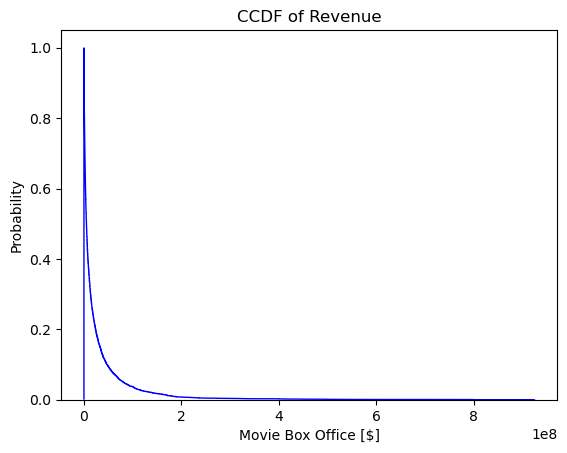

In [171]:
# Showing that revenue is heavy-tailed right skewed

# Remove zeros Revenues (missing revenues)
filtered_df_no_0s = filtered_df[filtered_df['Revenue'] > 1]

revenue_array = plt.hist(filtered_df_no_0s['Revenue'], bins=1000000, density=True, cumulative=-1,
                               color='blue', histtype='step', label="Revenue")
plt.xlabel('Movie Box Office [$]')
plt.ylabel('Probability')
plt.title('CCDF of Revenue')
plt.show()

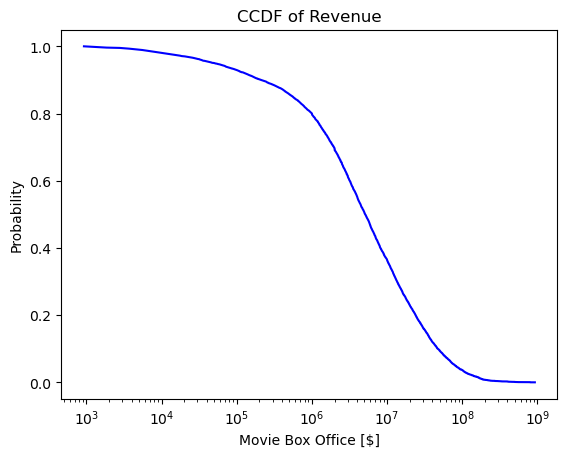

In [172]:
plt.plot(revenue_array[1][1:], revenue_array[0], label="Left-handed pitchers", color='blue')
plt.xscale('log')
plt.xlabel('Movie Box Office [$]')
plt.ylabel('Probability')
plt.title('CCDF of Revenue')
plt.show()

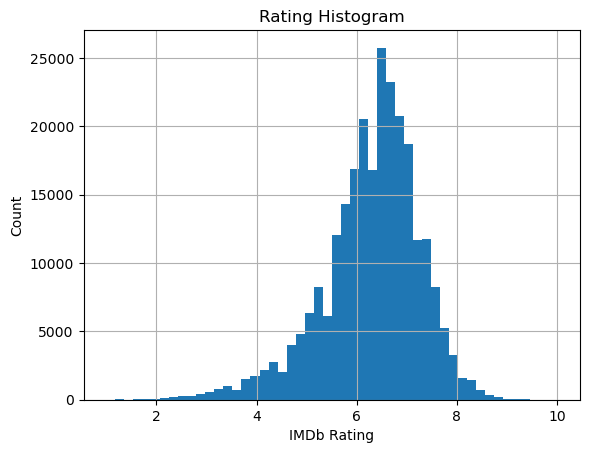

In [177]:
# Showing that rating is normal-like
filtered_df.hist(['Rating'],bins=50)
plt.xlabel('IMDb Rating')
plt.ylabel('Count')
plt.title('Rating Histogram')
plt.show()

As we can see from the previous plots:
- The Revenue of movies follows a right-skewed heavy-tailed distribution
- The Rating of movies follows a normal-like distribution

In order to normalize/scale these distributions, we use relevant techniques for each distribution:
- For a heavy-tailed distribution, we apply a logarithmic transformation
- For a normal distribution, we apply Z-score normalization

After these two normalizations, we then apply Min/Max scaling to have the same scale for the two distributions

In [269]:
# Assuming filtered_df is your DataFrame
columns_to_scale = ['Revenue', 'Rating']
actor_popularity_rank = filtered_df.copy()

# Z-score normalization for Rating then min max scaling
actor_popularity_rank['Rating'] = (actor_popularity_rank['Rating'] - actor_popularity_rank['Rating'].mean()) / actor_popularity_rank['Rating'].std()
actor_popularity_rank['Rating'] = (actor_popularity_rank['Rating']-actor_popularity_rank['Rating'].min())/(actor_popularity_rank['Rating'].max()-actor_popularity_rank['Rating'].min())


# log normalization of Revenue then min max scaling
actor_popularity_rank.loc[actor_popularity_rank['Revenue'] < 1, 'Revenue'] = 1
actor_popularity_rank['Revenue'] = actor_popularity_rank['Revenue'].apply(lambda x: np.log(x))
actor_popularity_rank['Revenue'] = (actor_popularity_rank['Revenue']-actor_popularity_rank['Revenue'].min())/(actor_popularity_rank['Revenue'].max()-actor_popularity_rank['Revenue'].min())

# Sort by 'Year' in descending order
actor_popularity_rank = actor_popularity_rank.sort_values(by='Year', ascending=False)

# Display the DataFrame
actor_popularity_rank.head(2)

,Actor Name,Movie name,Date,Rating,Revenue,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID),Actor age at movie release,Year
409758,Elvis Tsui,The Lovers,2017-05-05 00:00:00+00:00,0.640866,0.502492,1961-10-13,M,NaN,NaN,2017.0
409756,Charlie Yeung,The Lovers,2017-05-05 00:00:00+00:00,0.640866,0.502492,1974-05-23,F,NaN,NaN,2017.0


### Compute Actor Recognition Coefficient for each (Movie, Actor) pair
We define the Actor Recognition Coefficient to be a weighted average between the movie revenue and its rating.

DIEGO: WRITE FORMULA

In [157]:
# Compute Actor Recognition Coefficient for each (Movie, Actor) pair
columns_to_scale = ['Revenue', 'Rating']

#  Weights can be adjusted
weights = [1, 1]
actor_popularity_movie_coef = actor_popularity_rank

# Calculate weighted average of normalized rating and normalized revenue
actor_popularity_movie_coef['Recognition Coefficient'] = np.average(actor_popularity_rank[columns_to_scale], axis=1, weights=weights)

actor_popularity_movie_coef = actor_popularity_movie_coef.sort_values(by='Recognition Coefficient',ascending=False)

actor_popularity_movie_coef.head(2)

,Actor Name,Movie name,Date,Rating,Revenue,Actor date of birth,Actor gender,Actor ethnicity (Freebase ID),Actor age at movie release,Year,Recognition Coefficient
59934,Harry Dean Stanton,The Godfather Part II,1974-12-12 00:00:00+00:00,0.888889,0.909743,1926-07-14,M,NaN,48.0,1974.0,0.899316
59917,Al Pacino,The Godfather Part II,1974-12-12 00:00:00+00:00,0.888889,0.909743,1940-04-25,M,/m/0xnvg,34.0,1974.0,0.899316


### Compute Actor Recognition Coefficient for every Actor every Year
This is done by taking the mean of the Recognition Coefficient of the movies the Actor played in each year

In [158]:
# Compute Actor Recognition Coefficient for every Actor every Year
actor_movie_year = actor_popularity_movie_coef.groupby(['Actor Name', 'Year'])['Recognition Coefficient'].mean().reset_index()

actor_movie_year = actor_movie_year.sort_values(by='Year',ascending=True)

actor_movie_year.head(2)

,Actor Name,Year,Recognition Coefficient
24811,Charles Richman,1914.0,0.304444
66140,Jack Richardson,1914.0,0.322222


### Expand the dataset to include entries for all actors in each year
We're creating a DataFrame with all actor-year combinations from 1914 to 2012, putting the Actor Recognition Coefficient to zero if the actor does not have films in the corresponding year

In [159]:
# Create a DataFrame with all actor-year combinations from 1914 to 2012
years = list(range(1914, 2013))

# Get unique actor names 
actors = actor_movie_year['Actor Name'].unique()

# Create a MultiIndex DataFrame with all possible actor-year combinations
actor_year_combinations = pd.MultiIndex.from_product([actors, years], names=['Actor Name', 'Year']).to_frame(index=False)
actor_year_combinations.columns = ['Actor Name', 'Year']

# Merge the actor_year_combinations DataFrame with actor_movie_year to get the coefficients
all_actor_year = pd.merge(actor_year_combinations, actor_movie_year, on=['Actor Name', 'Year'], how='left')

# Fill missing values in the 'Recognition Coefficient' column with 0
all_actor_year['Recognition Coefficient'].fillna(0, inplace=True)

# Rename 'Recognition Coefficient' to 'Actor Year Coefficient'
all_actor_year.rename(columns={'Recognition Coefficient': 'Recognition Coefficient'}, inplace=True)

# Sort the result DataFrame
all_actor_year = all_actor_year.sort_values(by=['Year', 'Actor Name'], ascending=[True, True])

# Reset the index
all_actor_year.reset_index(drop=True, inplace=True)

display(all_actor_year)

,Actor Name,Year,Recognition Coefficient
0,50 Cent,1914,0.000000
1,A Martinez,1914,0.000000
2,A. E. Matthews,1914,0.000000
3,A. J. Bowen,1914,0.000000
4,A. J. Buckley,1914,0.000000
...,...,...,...
1788133,Şafak Sezer,2012,0.000000
1788134,Şener Şen,2012,0.000000
1788135,Žarko Potočnjak,2012,0.000000
1788136,Željko Ivanek,2012,0.710107


We now have a dataframe, that has a Recognition Coefficient value for each possible (Actor Name, Year) combination.
### Recognition of Past Years
Even if a certain actors does not play in any movie in a certain year, We consider that this actor would remain well-recognized to a certain extent during this year. To account for this effect, we add a certain fraction of the past year's Recognition Coefficient to the the current year's Recognition Coefficient


In [160]:
# Recognition of Past Years
previous_year_contribution = 0.5

actor_year_df = all_actor_year.copy()
actor_year_df.sort_values(by=['Actor Name', 'Year'], inplace=True)

# Initialize a dictionary to store the previous 'Coefficient with Past' values for each actor
prev_b_values = {}

# Iterate through the rows of the DataFrame to compute the values for column 'Coefficient with Past'
for index, row in actor_year_df.iterrows():
    actor = row['Actor Name']
    year = row['Year']
    a_value = row['Recognition Coefficient']
    
    if actor in prev_b_values:
        b_value = a_value + previous_year_contribution * prev_b_values[actor]
    else:
        b_value = a_value  # If there is no previous value, use A(actor, year) as-is
    
    actor_year_df.at[index, 'Coefficient with Past'] = b_value
    prev_b_values[actor] = b_value

actor_year_df['Year'] = pd.to_numeric(actor_year_df['Year'])

# Display the resulting DataFrame
display(actor_year_df)

,Actor Name,Year,Recognition Coefficient,Coefficient with Past
0,50 Cent,1914,0.0,0.000000
18062,50 Cent,1915,0.0,0.000000
36124,50 Cent,1916,0.0,0.000000
54186,50 Cent,1917,0.0,0.000000
72248,50 Cent,1918,0.0,0.000000
...,...,...,...,...
1715889,劉以達,2008,0.0,0.109802
1733951,劉以達,2009,0.0,0.054901
1752013,劉以達,2010,0.0,0.027451
1770075,劉以達,2011,0.0,0.013725


### General recognition
Now that we have the Actor Recognition Coefficient for every Actor in every Year, we can calculate the General Actor Recognition Coefficient by calculating the mean of the Recognition Coefficient through the years

In [161]:
general_recognition = actor_year_df.groupby(['Actor Name'])['Recognition Coefficient'].mean().reset_index()
general_recognition = general_recognition.sort_values(by='Recognition Coefficient',ascending=False)
(general_recognition).head(n=20)

,Actor Name,Recognition Coefficient
11568,Michael Caine,0.261674
14398,Robert De Niro,0.254534
3051,Clint Eastwood,0.249678
11387,Max von Sydow,0.241234
6164,Harrison Ford,0.238552
2899,Christopher Lee,0.238067
8395,John Wayne,0.235602
14407,Robert Duvall,0.231278
991,Anthony Hopkins,0.229393
15311,Sean Connery,0.227567


DIEGO: We can see that the most well-recognized actors are indeed actors that are well-known ....
Some of them are modern-day actors like Robert De Niro. However, we can also see that older well-recognized actors are accounted for as we find actors like John Wayne and Sean Connery

CONTINUE ...

### Actor Recognition Span Evolution Through time
In this section, the idea is to examine the span of the actors' Recognition through time. In other words, we are trying to find the year in which he started to be well-recognized and the year this recognition "ended". We do that by selecting the year range in which the Actor Recognition Coefficient is above a certain threshold.

DIEGO: CHECK AND COMPLETE
...

In [162]:
# Relative threshold for every actor, threshold being 30% of the Actor's Maximum Recognition

# Calculate fame threshold for each actor, threshold 50% of the maximum Recognition of this actor
fame_start_end_threshold = actor_year_df.groupby('Actor Name').max().reset_index()[['Actor Name','Recognition Coefficient']]
fame_start_end_threshold['threshold'] = 0.5*fame_start_end_threshold['Recognition Coefficient']
fame_start_end_threshold.drop(columns='Recognition Coefficient', inplace=True)


# Keep Recognition Values that are above the threshold
merged_df = pd.merge(actor_year_df, fame_start_end_threshold, on='Actor Name', how='left')
result_df = merged_df[merged_df['Recognition Coefficient'] > merged_df['threshold']]

# Find the minimum (first) and maximum (last) Year corresponding to these values
grouped = result_df.groupby('Actor Name').agg({'Year': ['min', 'max']})
grouped = grouped.reset_index()
grouped.columns = ['Actor Name', 'First Year', 'Last Year']  # Rename the columns
result_df = grouped.copy()  # Create a copy of grouped DataFrame

# Calculate the Range (last year - first year)
result_df['Range'] = result_df['Last Year'] - result_df['First Year']
result_df = result_df.sort_values(by='First Year')

result_df.head(1)

,Actor Name,First Year,Last Year,Range
441,Alfred St. John,1914,1945,31


In [163]:
# Group ranges for each first year by taking the mean and standard deviation of the range
filtered_actor_year_df = result_df.sort_values(by='First Year')
grouped_years = filtered_actor_year_df.groupby('First Year')['Range'].agg(['mean', 'std']).reset_index()

grouped_years.head(1)

,First Year,mean,std
0,1914,23.927273,23.011152


# Results about Actor Recognition

### Visualizing Average Span of Recognition through the years

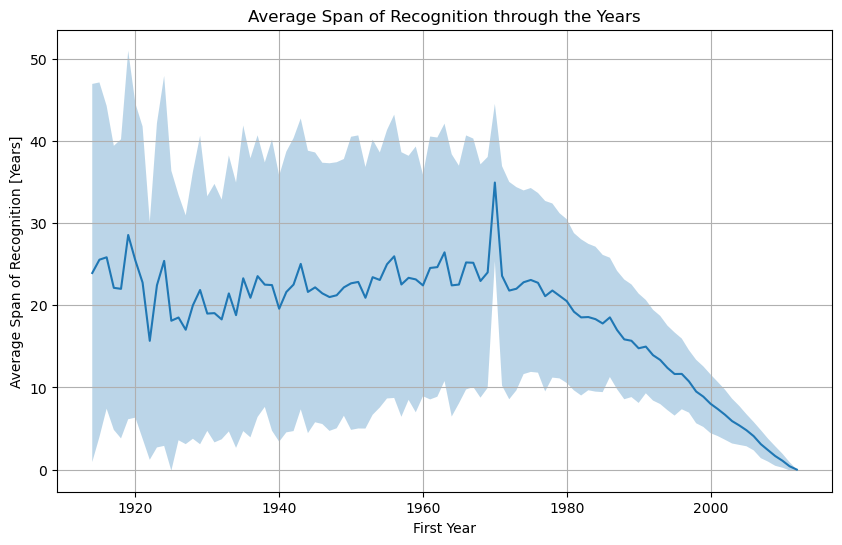

In [164]:
plt.figure(figsize=(10, 6))
plt.plot(grouped_years['First Year'],grouped_years['mean'],label='Mean')
plt.fill_between(grouped_years['First Year'], grouped_years['mean'] - grouped_years['std'], grouped_years['mean'] + grouped_years['std'], alpha=0.3, label='Std Dev')
plt.title('Average Span of Recognition through the Years')
plt.xlabel('First Year')
plt.ylabel('Average Span of Recognition [Years]')
plt.grid(True)
plt.show()

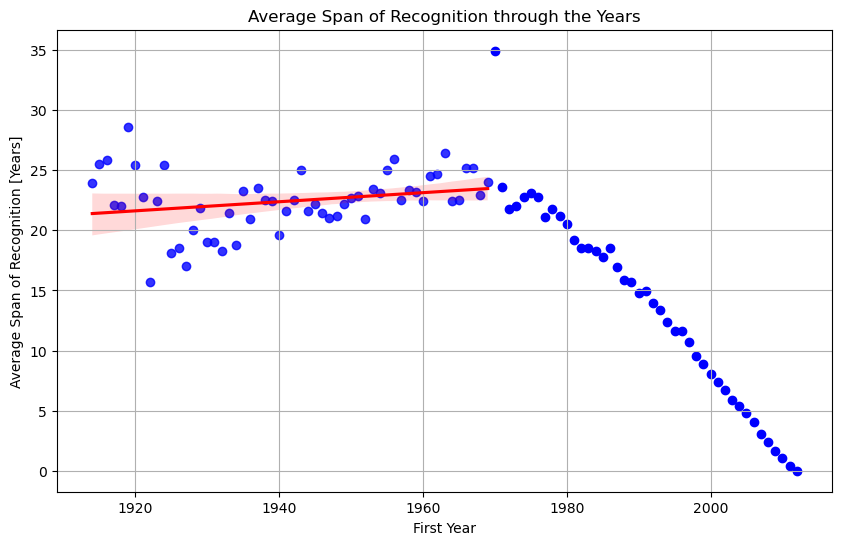

In [200]:
# Filter data before and after 1970
before_1970 = grouped_years[grouped_years['First Year'] < 1970]
after_1970 = grouped_years[grouped_years['First Year'] >= 1970]


# Plotting
plt.figure(figsize=(10, 6))

# Plotting regression line for before 1970
regplot_before_1970 = sns.regplot(x='First Year', y="mean", data=before_1970, ci=95, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, label='Before 1970')
# Plotting scatter points for after 1970
plt.scatter(after_1970['First Year'], after_1970['mean'], color="blue", marker="o", label='After 1970')


plt.title('Average Span of Recognition through the Years')
plt.xlabel('First Year')
plt.ylabel('Average Span of Recognition [Years]')
plt.grid(True)
plt.show()

DIEGO:!!

ANALYZE THIS GRAPH (SEE IF THERE ARE OTHER RELEVANT GRAPHS)

NOTE: starting about 1970 this range decrease since the data we have ends on 2012. Therefore actors starting to be recognized in 2012 (Having a First Year of 2012), would have a range of 0 years since their Last Year would also be considered to be 2012

DIEGO: CHECK AND COMPLETE

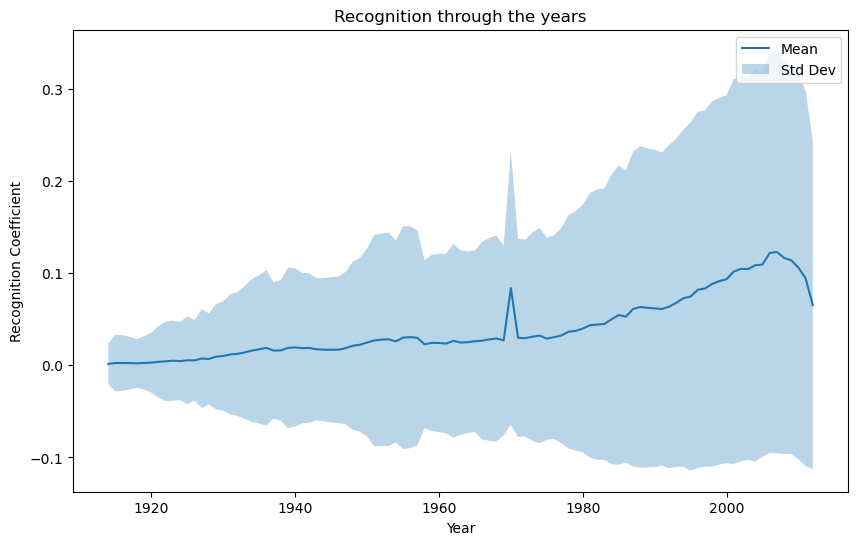

In [228]:
# Mean Value of Recognition coefficient through the Years
grouped_data = actor_year_df.groupby('Year')['Recognition Coefficient'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(grouped_data['Year'], grouped_data['mean'], label='Mean')
plt.fill_between(grouped_data['Year'], grouped_data['mean'] - grouped_data['std'], grouped_data['mean'] + grouped_data['std'], alpha=0.3, label='Std Dev')
plt.title('Recognition through the years')
plt.xlabel('Year')
plt.ylabel('Recognition Coefficient')
plt.legend()
plt.show()

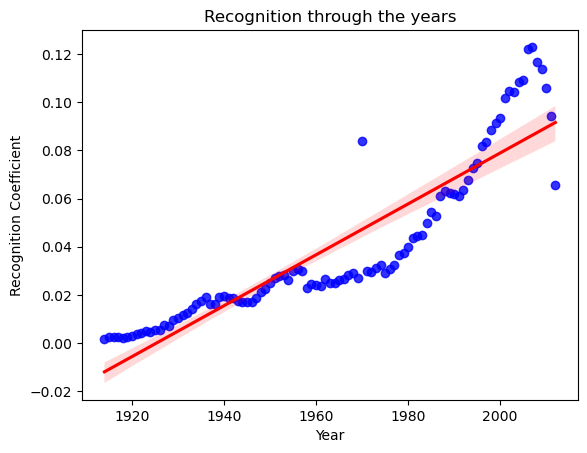

In [183]:
fig = sns.regplot(
    x='Year',
    y="mean",
    data=grouped_data,
    ci=95,
    scatter_kws={"color": "blue"},
    line_kws={"color": "red"},
)
plt.title('Recognition through the years')
plt.xlabel('Year')
plt.ylabel('Average Recognition Coefficient')
plt.show()

In [201]:
# Calculate Pearson Coefficient for before 1970
print(stats.pearsonr(grouped_data['Year'],grouped_data['mean']))

PearsonRResult(statistic=0.9058649059517087, pvalue=5.765482574647555e-38)


DIEGO: CHECK & CONTINUE (SAY THAT WE SEE BIG STANDARD DEVIATION IN 1ST PLOT)

From the previous Pearson test, since we have an extremely small p-value, we have strong evidence to reject the null-Hypothesis that suggests that there is no correlation between the Year and the Average Recognition Coefficient.
This result should be further explored in P3, to find the reasons for this relation.

### Plot Recognition of a specific actors

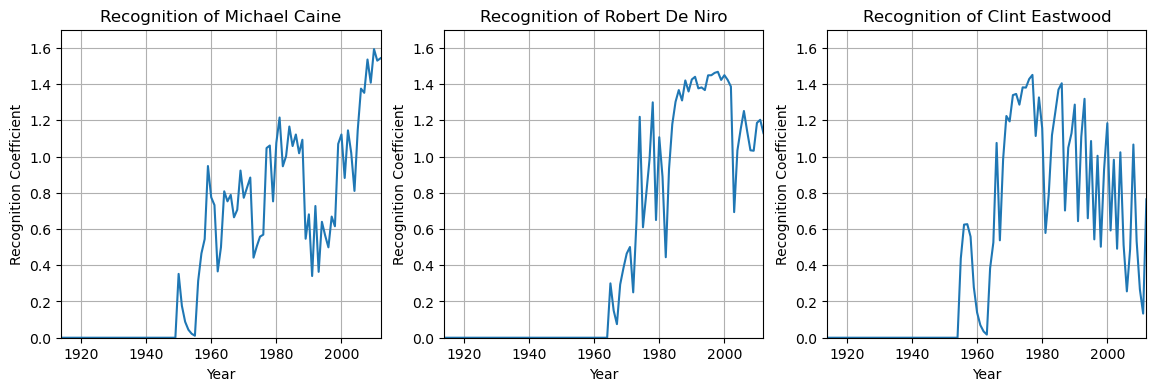

In [229]:
actor_names = ['Michael Caine','Robert De Niro','Clint Eastwood']


fig, axes = plt.subplots(1, len(actor_names), figsize=(14, 4))


for i, actor_name in enumerate(actor_names):
    particular_actor_df = actor_year_df[actor_year_df['Actor Name'] == actor_name]
    years = particular_actor_df['Year']
    coefficients = particular_actor_df['Coefficient with Past']
    axes[i].plot(years, coefficients)
    axes[i].set_title(f'Recognition of {actor_name}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Recognition Coefficient')
    axes[i].grid(True)

    axes[i].set_xlim(1914, 2012)
    axes[i].set_ylim(0, 1.7)

plt.show()

### Number of well-recognized actors per year

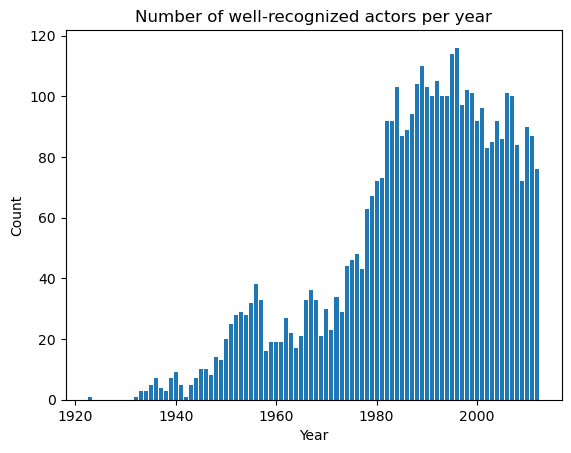

In [267]:
# Select the first 180 actors (int(len(general_recognition)/100)) in general_recognition and check in which years they are well-recognized

recognized_actors = general_recognition[:int(len(general_recognition)/100)]


# Calculate fame threshold for each actor, threshold 50% of the maximum Recognition of this actor
fame_start_end_threshold = actor_year_df.groupby('Actor Name').max().reset_index()[['Actor Name','Recognition Coefficient']]
fame_start_end_threshold['threshold'] = 0.5*fame_start_end_threshold['Recognition Coefficient']
fame_start_end_threshold.drop(columns='Recognition Coefficient', inplace=True)


# Keep Years that are above the threshold
actor_year_df2 = actor_year_df[actor_year_df['Actor Name'].isin(recognized_actors['Actor Name'])]
merged_df = pd.merge(actor_year_df2, fame_start_end_threshold, on='Actor Name', how='left')
result_df = merged_df[merged_df['Recognition Coefficient'] > merged_df['threshold']]

result_df2 = result_df.groupby('Year').count().reset_index()[['Year','Actor Name']]


plt.bar(result_df2['Year'],result_df2['Actor Name'])
plt.title('Number of well-recognized actors per year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

DIEGO: CHECK & CONTINUE

We see that the majority of the well-recognized actors are in years that follow 1980

# UNUSED BUT MIGHT BE USED

In [450]:
## REMOVED 6TH STEP BUT MIGHT BE USEFUL LATER
## 6TH STEP: REMOVE ACTORS WHO HAVE HAD SUCCESS BEFORE 1924 OR AFTER 2002
## THIS ALLOWS US TO REMOVE ACTORS WHO MIGHT STARTED ACTING BEFORE THE DATASET OR WHO CONTINUED ACTING AFTER
mask = actor_year_df[(actor_year_df['Year'] >= 2002) & (actor_year_df['Coefficient with Past'] > 0.1)]
actors_to_remove = mask['Actor Name'].unique()
filtered_actor_year_df = actor_year_df[~actor_year_df['Actor Name'].isin(actors_to_remove)]

mask = actor_year_df[(actor_year_df['Year'] <= 1924) & (actor_year_df['Coefficient with Past'] > 0.1)]
actors_to_remove = mask['Actor Name'].unique()
filtered_actor_year_df = filtered_actor_year_df[~actor_year_df['Actor Name'].isin(actors_to_remove)]
filtered_actor_year_df.reset_index(drop=True, inplace=True)

display(filtered_actor_year_df)

C:\Users\andre\AppData\Local\Temp\ipykernel_23656\2581459468.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_actor_year_df = filtered_actor_year_df[~actor_year_df['Actor Name'].isin(actors_to_remove)]


,Actor Name,Year,Recognition Coefficient,Coefficient with Past
0,Abhi Bhattacharya,1914,0.0,0.000000e+00
1,Abhi Bhattacharya,1915,0.0,0.000000e+00
2,Abhi Bhattacharya,1916,0.0,0.000000e+00
3,Abhi Bhattacharya,1917,0.0,0.000000e+00
4,Abhi Bhattacharya,1918,0.0,0.000000e+00
...,...,...,...,...
86323,Zachary Scott,2008,0.0,4.708475e-08
86324,Zachary Scott,2009,0.0,3.295933e-08
86325,Zachary Scott,2010,0.0,2.307153e-08
86326,Zachary Scott,2011,0.0,1.615007e-08


In [ ]:
## CHECKING FOR CORRECTNESS WITH Željko Ivanek IN 2012
zelko_ivanek_df = actor_popularity_movie_coef[(actor_popularity_movie_coef['Actor Name'] == 'Željko Ivanek') & (actor_popularity_movie_coef['Year'] == 2012)]
display(zelko_ivanek_df)

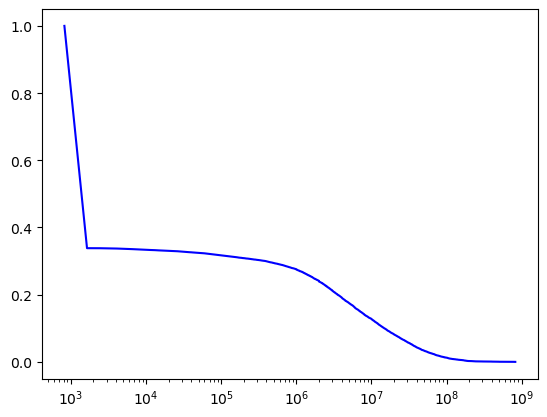

In [148]:
plt.plot(revenue_array[1][1:], revenue_array[0], label="Left-handed pitchers", color='blue')
plt.xscale('log')
plt.show()


In [149]:
# # ## 1ST STEP: RANKIZE RATING AND REVENUE
# columns_to_scale = ['Revenue', 'Rating']
# actor_popularity_rank = filtered_df.copy()
# ranks = filtered_df[columns_to_scale].rank()
# # normalized_ranks to be between 0 and 1
# normalized_ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())
# actor_popularity_rank[columns_to_scale] = normalized_ranks
# actor_popularity_rank = actor_popularity_rank.sort_values(by='Year', ascending=False)

# # display(actor_popularity_rank)

In [ ]:
## Empirical threshold

# fame_start_end_threshold = 0.1

# Keep Recognition Values that are above the threshold
# filtered_actor_year_df = actor_year_df[actor_year_df['Coefficient with Past'] > fame_start_end_threshold]
# grouped = filtered_actor_year_df.groupby('Actor Name').agg({'Year': ['min', 'max']})
# grouped = grouped.reset_index()
# grouped.columns = ['Actor Name', 'First Year', 'Last Year']  # Rename the columns
# result_df = grouped.copy()  # Create a copy of grouped DataFrame

# Find the minimum (first) and maximum (last) Year corresponding to these values
# Calculate the Range (last year - first year)
# result_df['Range'] = result_df['Last Year'] - result_df['First Year']
# result_df = result_df.sort_values(by='First Year')

# display(result_df)
